 ## Pruebas con MCPS

--- Prueba de MCPS con cálculo de ECRPS ---

Usando 180 puntos para predecir. Valor real: 0.1376

Ejecutando mcps_model.fit_predict()...

--- Resultados de la Evaluación ---
La distribución empírica tiene 7 resultados únicos.
ECRPS del modelo MCPS vs. Teórica: 0.3374


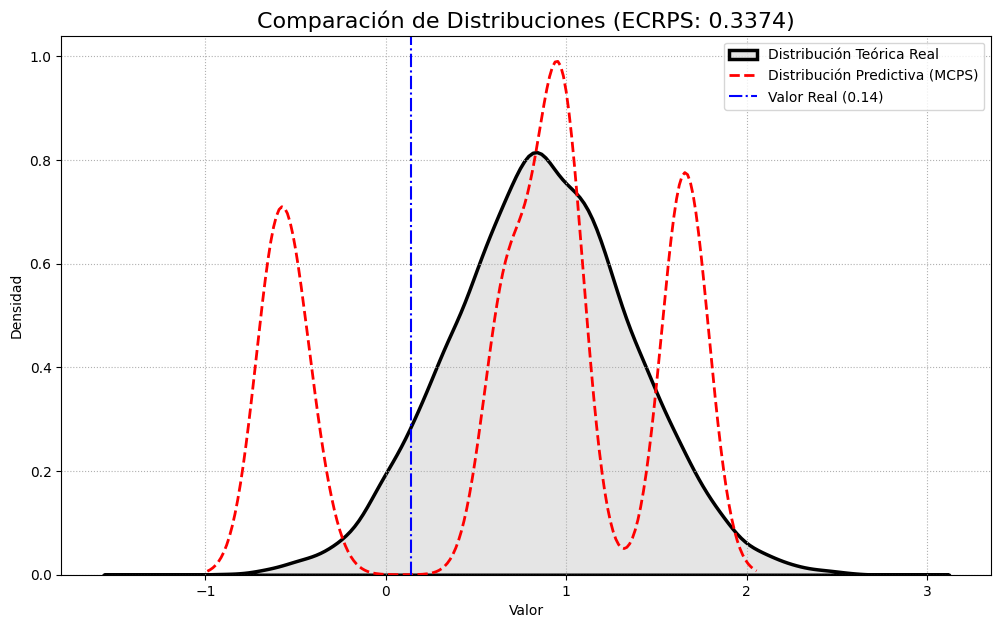

In [1]:
from pipeline import ARMASimulation, MondrianCPSModel, ecrps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if __name__ == "__main__":
    
    print("--- Prueba de MCPS con cálculo de ECRPS ---")
    
    SEED = 42
    rng_eval = np.random.default_rng(SEED) # Generador para la evaluación
    simulator = ARMASimulation(phi=[0.9], sigma=0.5, seed=SEED)
    full_series, full_errors = simulator.simulate(n=200)
    
    history_len = 180
    history_series, history_errors = full_series[:history_len], full_errors[:history_len]
    true_future_value = full_series[history_len]
    
    print(f"\nUsando {history_len} puntos para predecir. Valor real: {true_future_value:.4f}")
    
    mcps_model = MondrianCPSModel(n_lags=12, n_bins=8, test_size=0.3, random_state=SEED, verbose=False)
    
    print("\nEjecutando mcps_model.fit_predict()...")
    predictive_distribution = mcps_model.fit_predict(history_series)
    
    # --- CÁLCULO DE MÉTRICAS (NUEVA SECCIÓN) ---
    
    # 1. Extraer valores y probabilidades de la salida del modelo
    values = [d['value'] for d in predictive_distribution]
    probs = [d['probability'] for d in predictive_distribution]
    
    # 2. Generar muestras a partir de la distribución empírica (PARA EVALUACIÓN)
    n_samples_for_eval = 10000
    samples_from_model = rng_eval.choice(
        values, size=n_samples_for_eval, p=probs, replace=True
    )
    
    # 3. Obtener las muestras de la distribución teórica real
    theoretical_samples = simulator.get_true_next_step_samples(history_series, history_errors, n_samples=n_samples_for_eval)
    
    # 4. Calcular el ECRPS
    score_ecrps = ecrps(samples_from_model, theoretical_samples)
    
    print("\n--- Resultados de la Evaluación ---")
    print(f"La distribución empírica tiene {len(values)} resultados únicos.")
    print(f"ECRPS del modelo MCPS vs. Teórica: {score_ecrps:.4f}")
    
    # --- VISUALIZACIÓN ---
    expected_value = np.sum(np.array(values) * np.array(probs))
    
    plt.figure(figsize=(12, 7))
    sns.kdeplot(theoretical_samples, label='Distribución Teórica Real', color='black', lw=2.5, fill=True, alpha=0.1)
    sns.kdeplot(samples_from_model, label='Distribución Predictiva (MCPS)', color='red', linestyle='--', lw=2)
    plt.axvline(true_future_value, color='blue', linestyle='-.', label=f'Valor Real ({true_future_value:.2f})')
    
    # Añadir el ECRPS al título para un informe completo
    plt.title(f"Comparación de Distribuciones (ECRPS: {score_ecrps:.4f})", fontsize=16)
    
    plt.xlabel("Valor"); plt.ylabel("Densidad"); plt.legend(); plt.grid(True, ls=':')
    plt.show()

# Aplicación del codigo

## Prueba con 2 Escenarios

--- INICIANDO PRUEBA RÁPIDA CON 2 ESCENARIOS Y GRÁFICOS ACTIVADOS ---
✅ Gráficos de densidad activados. Se guardarán en la carpeta: 'plots_densidades_por_escenario'
Ejecuting 2 scenarios in 1 batches

BATCH 1/1 (Scenarios 1-2)
    Sublote 1/1


      Escenarios: 100%|██████████| 2/2 [13:15<00:00, 397.86s/it]


  Cleaning up batch memory...
✅ 22 results saved to './resultados/resultados_prueba_2_escenarios.xlsx'


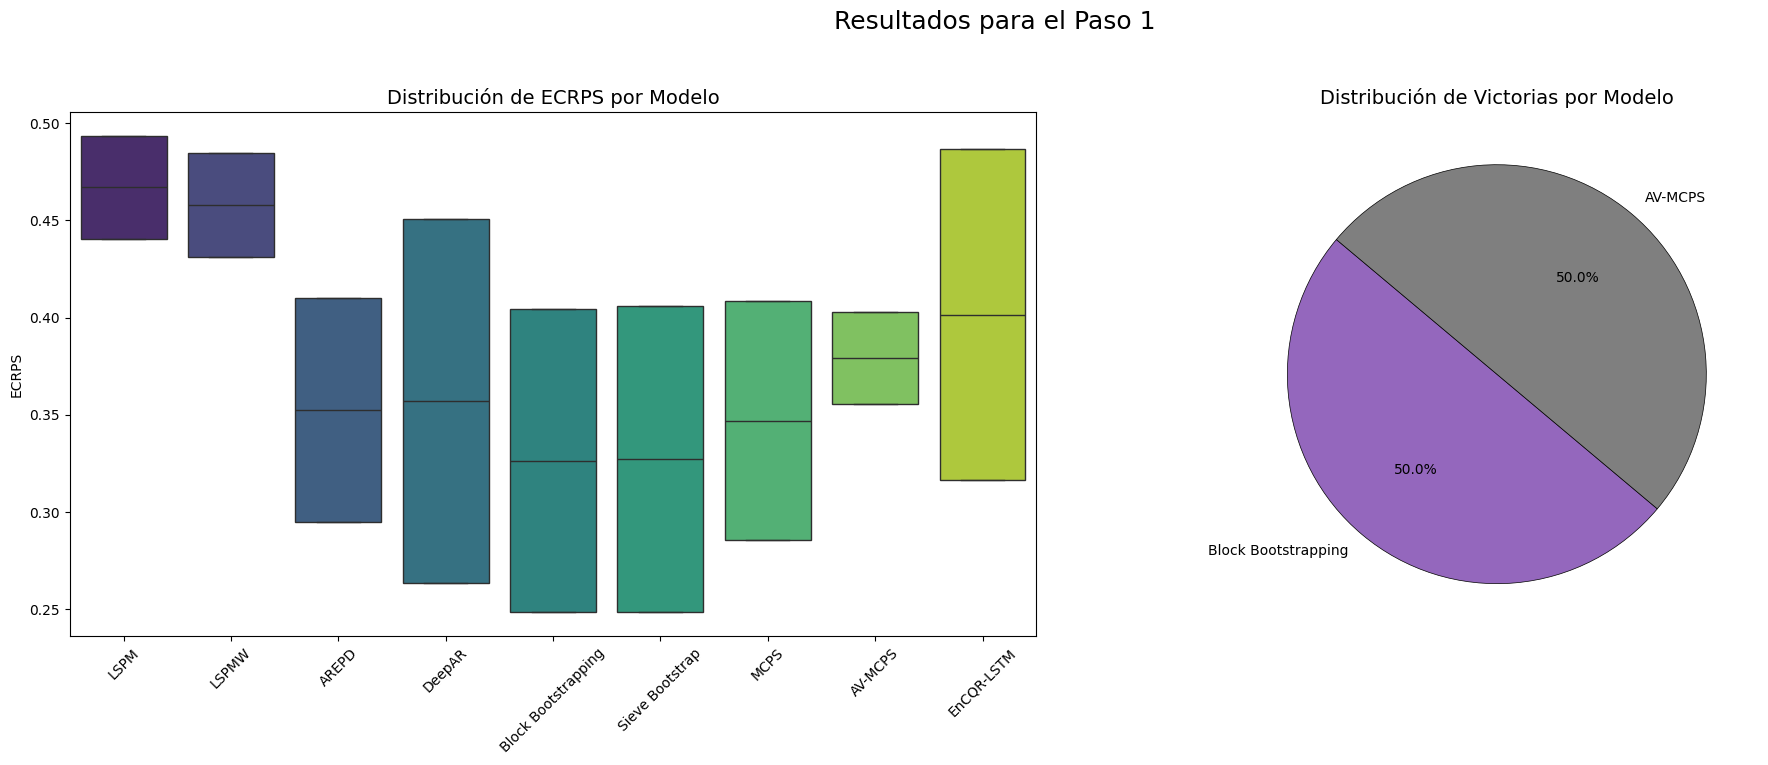

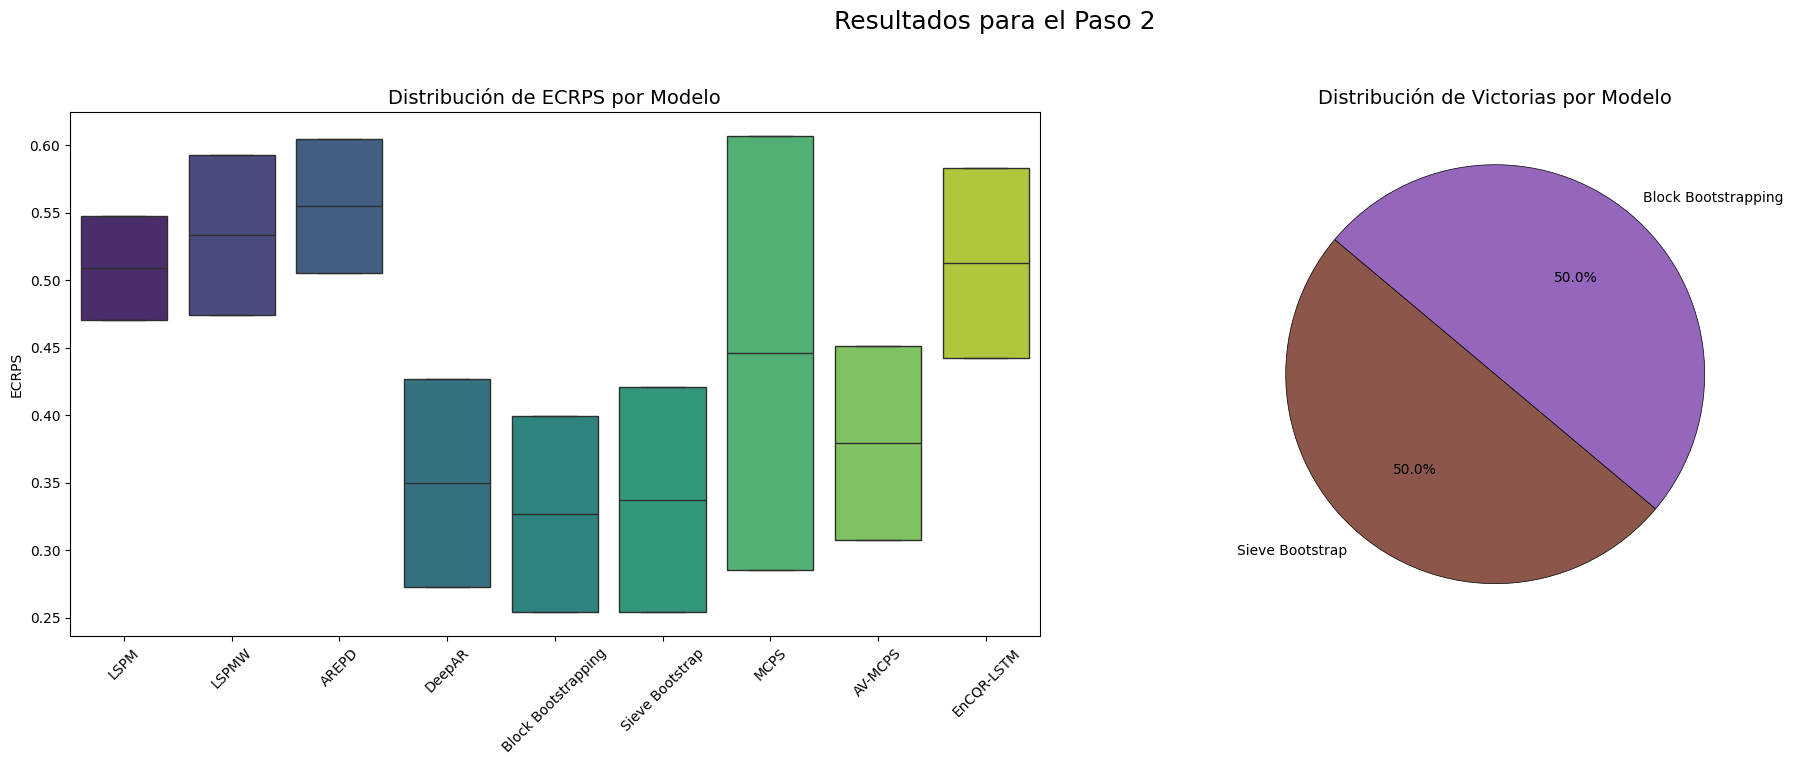

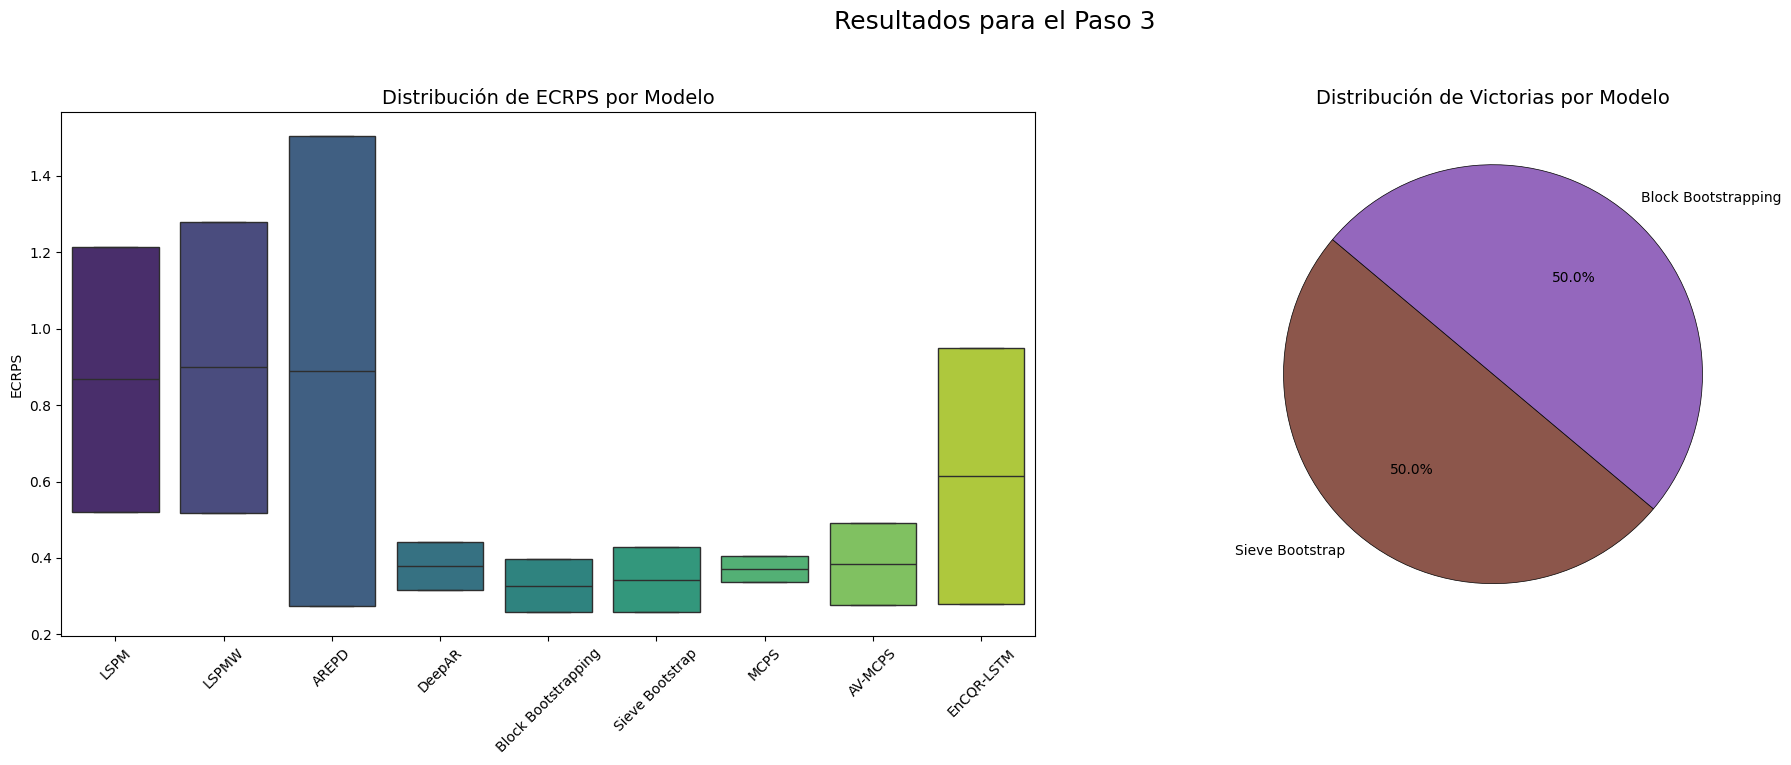

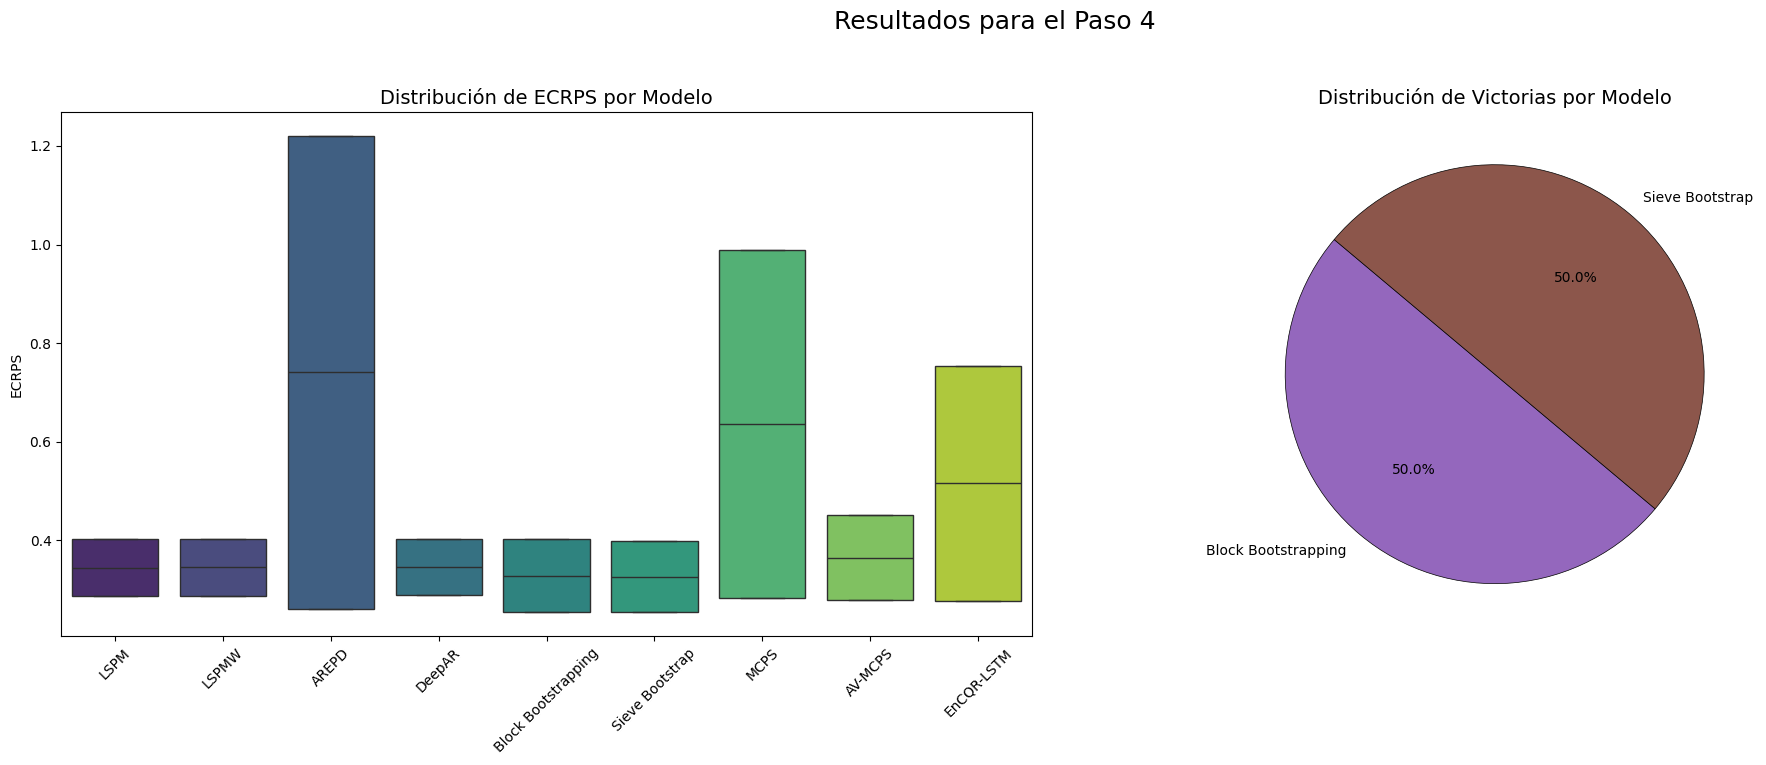

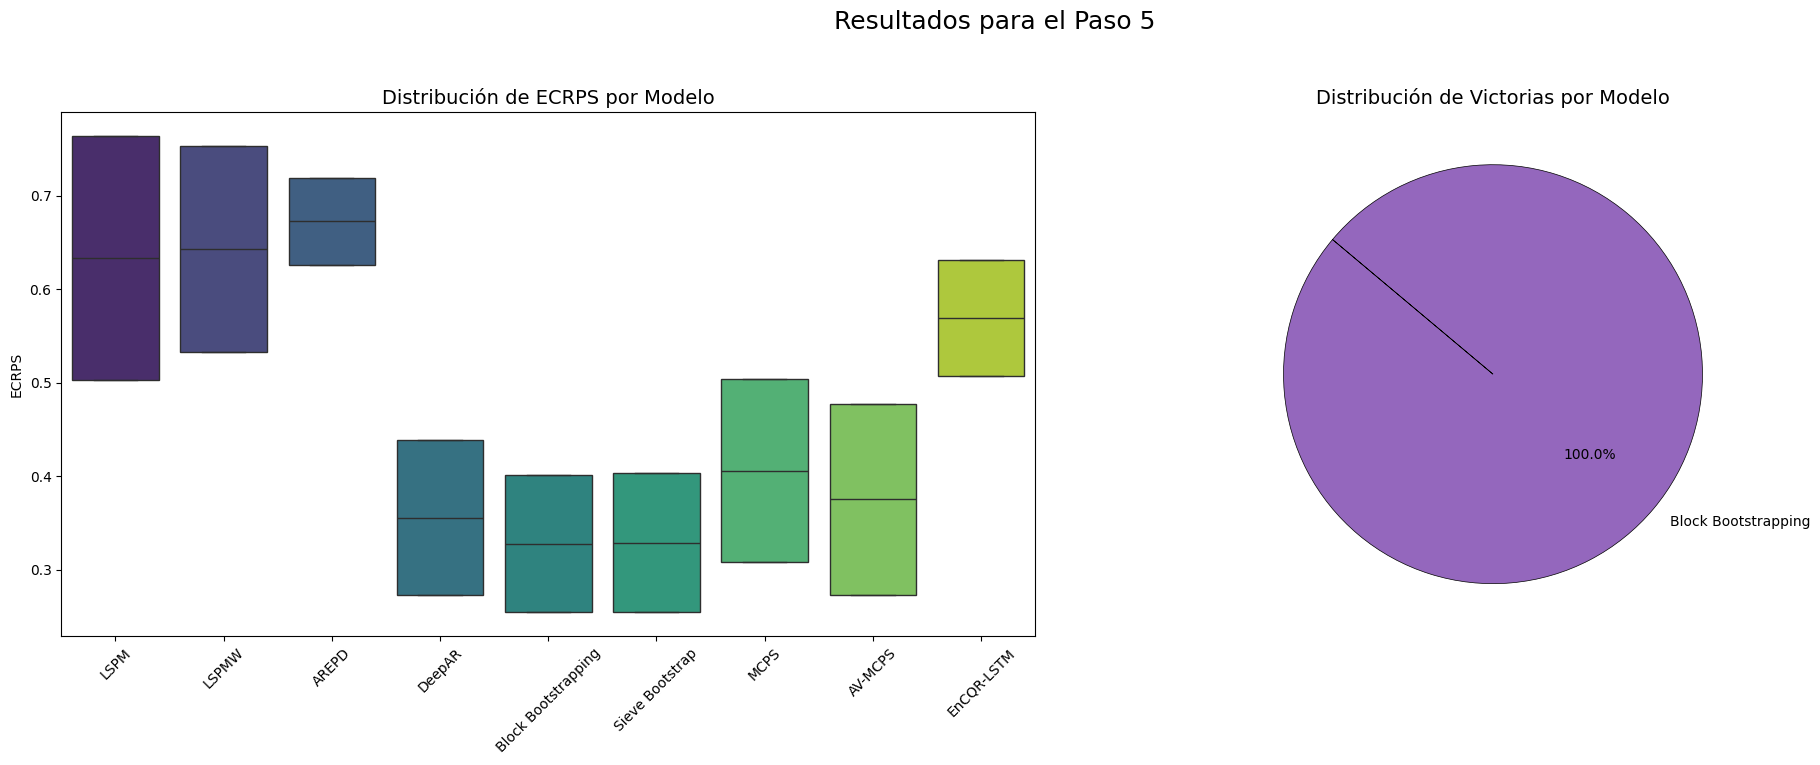

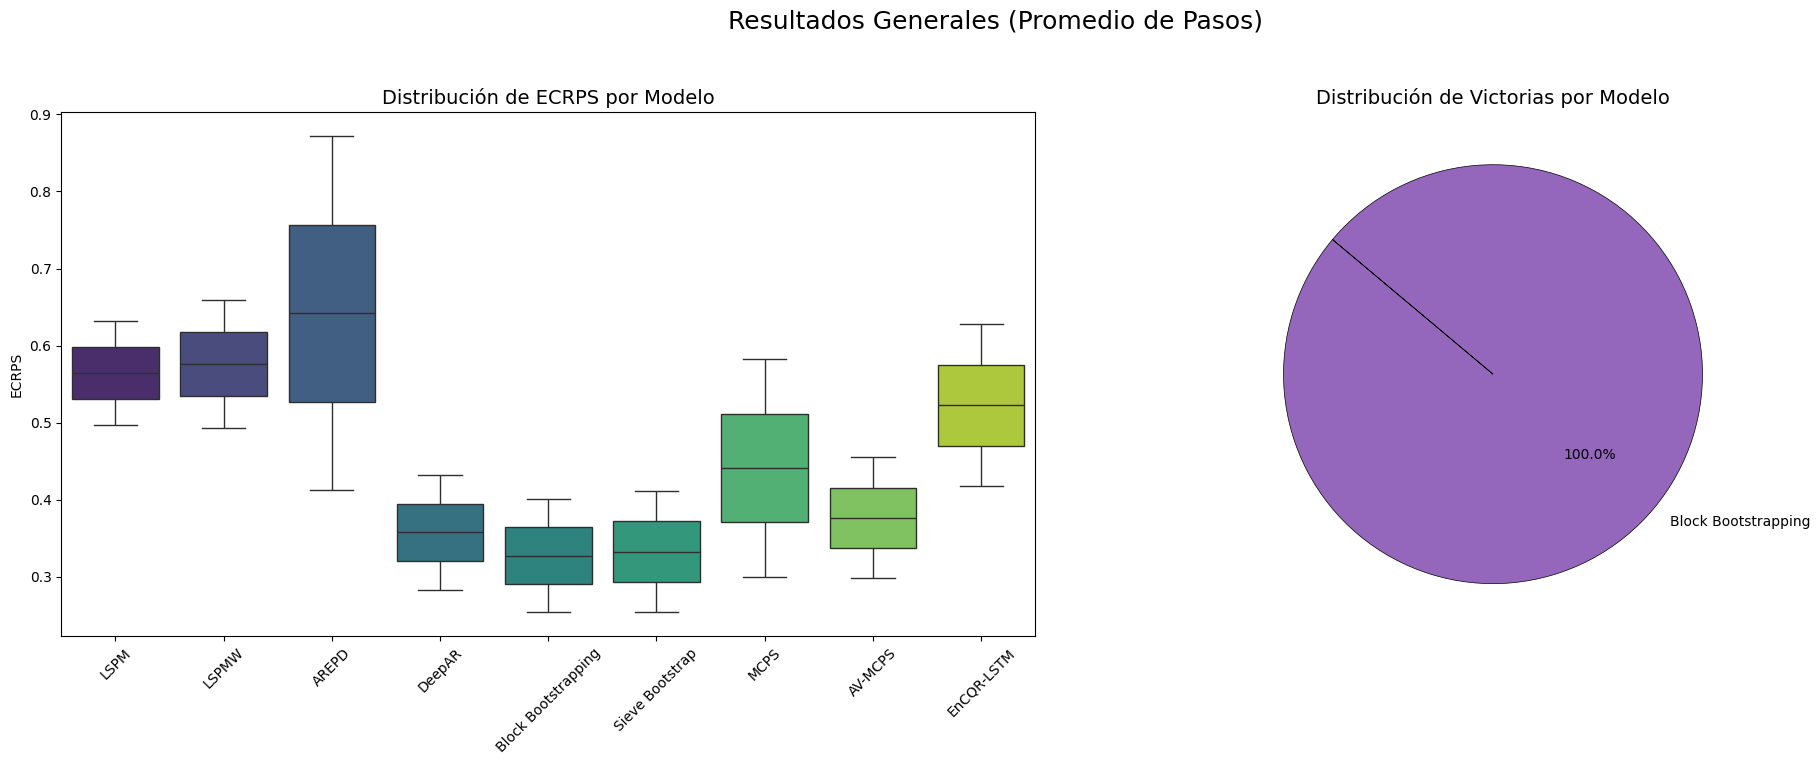


--- PRUEBA RÁPIDA FINALIZADA ---


In [1]:
from pipeline import ScenarioRunnerMejorado
import warnings

warnings.filterwarnings("ignore")
# ============================================================================
# BLOQUE DE EJECUCIÓN DE PRUEBA (CON GRÁFICOS)
# ============================================================================
if __name__ == "__main__":
    print("--- INICIANDO PRUEBA RÁPIDA CON 2 ESCENARIOS Y GRÁFICOS ACTIVADOS ---")
    
    # Se crea una instancia del corredor de escenarios.
    # La semilla asegura que los resultados sean replicables.
    runner_test = ScenarioRunnerMejorado(seed=420)
    
    runner_test.run(
        n_scenarios=2, 
        plot=True, 
        excel_filename="./resultados/resultados_prueba_2_escenarios.xlsx"
    )
    
    print("\n--- PRUEBA RÁPIDA FINALIZADA ---")

## Prueba con los 120 Escenarios

In [ ]:
from pipeline import ScenarioRunnerMejorado

# Configuración óptima para 120 escenarios:
runner = ScenarioRunnerMejorado(seed=420)
runner.run(
    n_scenarios=120,
    excel_filename="resultados_finales.xlsx",
    plot=False,            # Desactivar gráficos para acelerar
    batch_size=20,        # Lotes más pequeños
    restart_every=5       # Reiniciar pool cada 5 escenarios
)

print("\n✅ Simulación completa con 120 escenarios finalizada.")

Ejecuting 120 scenarios in 6 batches

BATCH 1/6 (Scenarios 1-20)
    Sublote 1/4


      Escenarios:   0%|          | 0/5 [00:00<?, ?it/s]

### Analisis de los ECRPS

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare
from dieboldmariano import dm_test
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import networkx as nx
from collections import defaultdict # Necesario para la nueva función

def _crear_y_guardar_boxplot(df: pd.DataFrame, model_cols: list, title: str, filepath: str):
    """
    Función auxiliar para generar y guardar dos diagramas de caja.
    """
    if df.empty:
        return

    epsilon = 0.1
    bigotes_superiores = []
    for modelo in model_cols:
        data = df[modelo].dropna()
        if not data.empty:
            Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
            bigote_superior = Q3 + 1.5 * (Q3 - Q1)
            bigotes_superiores.append(bigote_superior)

    limite_superior = max(bigotes_superiores) + epsilon if bigotes_superiores else None

    # Boxplot Completo
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df[model_cols], showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"8"})
    plt.title(f"{title}\n(N={len(df)} datos)", fontsize=16, weight='bold')
    plt.ylabel('ECRPS (Menor es mejor)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    filepath_completo = filepath.replace('.png', '_completo.png')
    plt.savefig(filepath_completo, dpi=300)
    plt.close()
    print(f"  -> Boxplot completo guardado en: {filepath_completo}")

    # Boxplot Acotado
    if limite_superior is not None:
        plt.figure(figsize=(12, 8))
        sns.boxplot(data=df[model_cols], showmeans=True,
                    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"8"})
        plt.title(f"{title} (Acotado)\n(N={len(df)} datos)", fontsize=16, weight='bold')
        plt.ylabel('ECRPS (Menor es mejor)', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.ylim(bottom=0, top=limite_superior)
        plt.tight_layout()
        filepath_acotado = filepath.replace('.png', '_acotado.png')
        plt.savefig(filepath_acotado, dpi=300)
        plt.close()
        print(f"  -> Boxplot acotado guardado en: {filepath_acotado}")

def _ejecutar_analisis_estadistico(df_analisis: pd.DataFrame, model_cols: list, alpha: float):
    """
    Ejecuta el pipeline de análisis estadístico: Friedman y Diebold-Mariano post-hoc.
    """
    # 1. Prueba Friedman
    try:
        _, friedman_p = friedmanchisquare(*[df_analisis[col] for col in model_cols])
        if friedman_p >= alpha:
            print("  -> Conclusión Friedman: No hay diferencias globales significativas.")
            return None
    except ValueError:
        print("  -> ADVERTENCIA: No se pudo ejecutar Friedman (datos insuficientes/invariantes).")
        pass

    # 2. Comparaciones por Pares con Prueba Diebold-Mariano
    try:
        comparisons = list(combinations(model_cols, 2))
        p_values_sin_corregir = []
        real_values_dummy = np.zeros(len(df_analisis))

        for m1, m2 in comparisons:
            _, p_value = dm_test(
                real_values_dummy,
                df_analisis[m1].values,
                df_analisis[m2].values,
                h=1
            )
            p_values_sin_corregir.append(p_value)

        reject, p_values_corregidos, _, _ = multipletests(p_values_sin_corregir, alpha=alpha, method='holm')
    except Exception as e:
        print(f"  -> ADVERTENCIA: No se pudo ejecutar Diebold-Mariano ({e}).")
        return None

    df_comparaciones = pd.DataFrame({
        'Modelo A': [c[0] for c in comparisons], 'Modelo B': [c[1] for c in comparisons],
        'P-Valor Corregido': p_values_corregidos, 'Significativo': ['SÍ' if r else 'NO' for r in reject]
    }).sort_values('P-Valor Corregido')

    # Matriz de Significancia (se sigue creando para la lógica interna, pero no se exportará)
    df_matriz = pd.DataFrame(index=model_cols, columns=model_cols)
    for _, row in df_comparaciones.iterrows():
        df_matriz.loc[row['Modelo A'], row['Modelo B']] = row['Significativo']
    df_matriz_triangular = df_matriz.where(np.triu(np.ones(df_matriz.shape), k=1).astype(bool))

    # 4. Ranking
    mean_ecrps = df_analisis[model_cols].mean()
    wins = {model: 0 for model in model_cols}
    for _, row in df_comparaciones[df_comparaciones['Significativo'] == 'SÍ'].iterrows():
        if mean_ecrps[row['Modelo A']] < mean_ecrps[row['Modelo B']]:
            wins[row['Modelo A']] += 1
        else:
            wins[row['Modelo B']] += 1
    df_ranking = pd.DataFrame.from_dict(wins, orient='index', columns=['Victorias Significativas'])
    df_ranking['ECRPS Promedio'] = mean_ecrps
    df_ranking = df_ranking.sort_values(by=['Victorias Significativas', 'ECRPS Promedio'], ascending=[False, True])
    df_ranking.insert(0, 'Rank', range(1, len(df_ranking) + 1))

    # 5. Grupos de Similitud Estadística
    G = nx.Graph()
    G.add_nodes_from(model_cols)
    for _, row in df_comparaciones[df_comparaciones['Significativo'] == 'NO'].iterrows():
        G.add_edge(row['Modelo A'], row['Modelo B'])
    
    grupos_ordenados = sorted(list(nx.connected_components(G)), key=lambda g: mean_ecrps[list(g)].mean())
    grupos_formateados = []
    for i, grupo in enumerate(grupos_ordenados):
        modelos_ordenados = sorted(list(grupo), key=lambda m: mean_ecrps[m])
        ecrps_modelos = [f"{mean_ecrps[modelo]:.6f}" for modelo in modelos_ordenados]
        grupos_formateados.append({
            'Grupo': f'Grupo {chr(65 + i)}',
            'Modelos': ', '.join(modelos_ordenados),
            'ECRPS Promedio (Modelos)': ', '.join(ecrps_modelos)
        })
    df_grupos = pd.DataFrame(grupos_formateados)

    return {
        'ranking': df_ranking, 'grupos': df_grupos, 'matriz': df_matriz_triangular,
        'comparaciones': df_comparaciones
    }

def _crear_dataframe_resumen(resultados_combinados: dict, model_cols: list):
    """
    Crea un DataFrame resumen de los resultados en todas las particiones.
    """
    resumen_data = []
    for modelo in model_cols:
        mejor_en = [f"{part[0]}-{part[1]}" for part, res in resultados_combinados.items() if res and res['ranking'].loc[modelo, 'Rank'] == 1]
        recomendable_en = [f"{part[0]}-{part[1]}" for part, res in resultados_combinados.items() if res and res['ranking'].loc[modelo, 'Rank'] <= 3]
        resumen_data.append({
            'Modelo': modelo,
            'Veces Mejor (Rank 1)': len(mejor_en),
            'Veces Recomendable (Top 3)': len(recomendable_en),
            'Es Mejor En': ', '.join(mejor_en) if mejor_en else 'Ninguna',
            'Es Recomendable En': ', '.join(recomendable_en) if recomendable_en else 'Ninguna'
        })
    df_resumen = pd.DataFrame(resumen_data)
    return df_resumen.sort_values(by=['Veces Mejor (Rank 1)', 'Veces Recomendable (Top 3)'], ascending=[False, False])

# --- NUEVA FUNCIÓN PARA LA HOJA DE POSICIONES ---
def _crear_dataframe_posiciones(resultados_combinados: dict, model_cols: list):
    """
    Crea un DataFrame que cuenta cuántas veces cada modelo terminó en cada posición del ranking.
    """
    # Usamos defaultdict para facilitar el conteo
    posicion_counts = defaultdict(lambda: defaultdict(int))

    # Recorrer todos los resultados para obtener los rankings
    for _, resultados in resultados_combinados.items():
        if resultados and 'ranking' in resultados:
            ranking_df = resultados['ranking']
            for modelo, data in ranking_df.iterrows():
                rank = data['Rank']
                posicion_counts[modelo][rank] += 1
    
    # Preparar los datos para el DataFrame final
    data_para_df = []
    columnas_posicion = [
        'Primer Lugar', 'Segundo Lugar', 'Tercer Lugar', 'Cuarto Lugar',
        'Quinto Lugar', 'Sexto Lugar', 'Séptimo Lugar', 'Octavo Lugar'
    ]

    for modelo in model_cols:
        fila = {'Modelo': modelo}
        for i, col_name in enumerate(columnas_posicion):
            rank = i + 1
            fila[col_name] = posicion_counts[modelo].get(rank, 0)
        data_para_df.append(fila)
        
    df_posiciones = pd.DataFrame(data_para_df)
    return df_posiciones

def generar_informe_completo(ruta_excel_entrada: str, alpha: float = 0.05):
    """
    Orquesta todo el proceso de análisis y generación de informes.
    """
    print("="*70 + f"\nGENERANDO INFORME DE ANÁLISIS COMPLETO (alpha={alpha})\n" + "="*70)

    # 1. Configuración de directorios
    ruta_base = "analisis"
    ruta_plots = os.path.join(ruta_base, "box_plots")
    ruta_excel_salida = os.path.join(ruta_base, "informe_analisis_completo.xlsx")
    os.makedirs(ruta_plots, exist_ok=True)
    print(f"Directorio de salida: '{ruta_base}/'")

    # 2. Carga y preparación de datos
    try:
        df_original = pd.read_excel(ruta_excel_entrada)
    except FileNotFoundError:
        print(f"❌ ERROR: No se encontró el archivo: {ruta_excel_entrada}"); return
    print(f"✅ Archivo '{ruta_excel_entrada}' cargado.")
    
    df_base = df_original[pd.to_numeric(df_original['Paso'], errors='coerce').notna()].copy()
    df_base['Valores de AR'] = df_base['Valores de AR'].astype(str)
    df_base['Valores MA'] = df_base['Valores MA'].astype(str)
    model_cols = [c for c in df_original if c not in ['Paso', 'Valores de AR', 'Valores MA', 'Distribución', 'Varianza error', 'Mejor Modelo']]

    # 3. Definición de escenarios de análisis
    conjuntos = {}
    pasos = sorted(df_base['Paso'].dropna().unique())
    for paso in pasos:
        conjuntos[('Paso', f"Paso_{int(paso)}")] = df_base[df_base['Paso'] == paso]

    sim_masks = {
        'AR': (df_base['Valores de AR'].str.len() > 2) & (df_base['Valores MA'].str.len() <= 2),
        'MA': (df_base['Valores MA'].str.len() > 2) & (df_base['Valores de AR'].str.len() <= 2),
        'ARMA': (df_base['Valores de AR'].str.len() > 2) & (df_base['Valores MA'].str.len() > 2)
    }
    for sim, mask in sim_masks.items():
        conjuntos[('Simulacion', sim)] = df_base[mask]

    for paso in pasos:
        for sim, mask in sim_masks.items():
            df_subset = df_base[(df_base['Paso'] == paso) & mask]
            if not df_subset.empty:
                conjuntos[('Combinado', f"{sim}_Paso_{int(paso)}")] = df_subset
    
    conjuntos[('Total', 'Total')] = df_base

    # 4. Procesamiento de cada escenario
    resultados_globales = {}
    for (tipo, nombre), df_escenario in conjuntos.items():
        print(f"\n===== PROCESANDO: {tipo} - {nombre} (N={len(df_escenario)}) =====")
        if len(df_escenario) < 10:
            print("  -> ADVERTENCIA: Se omite por tener < 10 datos (análisis poco fiable)."); continue
        
        ruta_plot = os.path.join(ruta_plots, f"boxplot_{tipo}_{nombre}.png")
        _crear_y_guardar_boxplot(df_escenario, model_cols, f"ECRPS - {nombre}", ruta_plot)
        
        resultados = _ejecutar_analisis_estadistico(df_escenario, model_cols, alpha)
        if resultados:
            resultados_globales[(tipo, nombre)] = resultados

    # 5. Consolidación y exportación a Excel
    print(f"\n--- Guardando informe consolidado en '{ruta_excel_salida}' ---")
    with pd.ExcelWriter(ruta_excel_salida, engine='openpyxl') as writer:
        # Hoja 1: Resumen General
        df_resumen = _crear_dataframe_resumen(resultados_globales, model_cols)
        df_resumen.to_excel(writer, sheet_name="Resumen_General", index=False)

        # Hoja 2: Posiciones (NUEVA)
        df_posiciones = _crear_dataframe_posiciones(resultados_globales, model_cols)
        df_posiciones.to_excel(writer, sheet_name="Posiciones", index=False)

        # Hojas de datos consolidados
        for clave_res, nombre_hoja in [("ranking", "Ranking_Detallado"), ("grupos", "Grupos_Similitud"), ("comparaciones", "Comparaciones_Pares")]:
            dfs = []
            for (tipo, particion), res in resultados_globales.items():
                if res: # Asegurarse que el resultado no es None
                    df = res[clave_res].reset_index().rename(columns={'index': 'Modelo'}) if clave_res == 'ranking' else res[clave_res]
                    df.insert(0, 'Tipo Particion', tipo); df.insert(1, 'Particion', particion)
                    dfs.append(df)
            if dfs: pd.concat(dfs, ignore_index=True).to_excel(writer, sheet_name=nombre_hoja, index=False)

        # --- SECCIÓN ELIMINADA ---
        # Ya no se escriben las hojas individuales de matrices.

    print("✅ Proceso completado con éxito.")
    print("="*70 + "\n### INFORME GENERADO ###")
    print(f"1. Informe Excel: '{ruta_excel_salida}'")
    print(f"2. Gráficos: '{ruta_plots}'")
    print(f"3. Escenarios analizados: {len(resultados_globales)}")

# --- Punto de Entrada ---
if __name__ == '__main__':
    archivo_entrada = "./resultados/resultados_finales.xlsx"
    if os.path.exists(archivo_entrada):
        generar_informe_completo(ruta_excel_entrada=archivo_entrada, alpha=0.05)
    else:
        print(f"❌ ERROR: El archivo de entrada no se encontró en '{archivo_entrada}'.")
        print("Asegúrate de que la ruta sea correcta o crea un archivo de ejemplo.")

GENERANDO INFORME DE ANÁLISIS COMPLETO (alpha=0.05)
Directorio de salida: 'analisis/'
✅ Archivo './resultados/resultados_finales.xlsx' cargado.

===== PROCESANDO: Paso - Paso_1 (N=120) =====
  -> Boxplot completo guardado en: analisis\box_plots\boxplot_Paso_Paso_1_completo.png
  -> Boxplot acotado guardado en: analisis\box_plots\boxplot_Paso_Paso_1_acotado.png

===== PROCESANDO: Paso - Paso_2 (N=120) =====
  -> Boxplot completo guardado en: analisis\box_plots\boxplot_Paso_Paso_2_completo.png
  -> Boxplot acotado guardado en: analisis\box_plots\boxplot_Paso_Paso_2_acotado.png

===== PROCESANDO: Paso - Paso_3 (N=120) =====
  -> Boxplot completo guardado en: analisis\box_plots\boxplot_Paso_Paso_3_completo.png
  -> Boxplot acotado guardado en: analisis\box_plots\boxplot_Paso_Paso_3_acotado.png

===== PROCESANDO: Paso - Paso_4 (N=120) =====
  -> Boxplot completo guardado en: analisis\box_plots\boxplot_Paso_Paso_4_completo.png
  -> Boxplot acotado guardado en: analisis\box_plots\boxplot_Paso